In [1]:
!pip install --upgrade torchtest

  Using cached torchtest-0.5-py3-none-any.whl (6.8 kB)
  Using cached torch-1.5.0-cp37-cp37m-manylinux1_x86_64.whl (752.0 MB)
ERROR: Could not install packages due to an EnvironmentError: [Errno 28] No space left on device



In [2]:
"""IMPORTS"""

import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from torchtest import assert_vars_change, assert_vars_same, test_suite
from scipy.ndimage import gaussian_filter1d

In [3]:
"""TESTING CODE BLOCK"""

torch.manual_seed(1)

def get_gradient_norm(model):
  norms = 0
  for param in model.parameters():
    norms += param.grad.data.detach().norm(2)
  return norms

def visualize_history_norm(history, history_name, zoom_axis=[], sigma=5):
  plt.plot(gaussian_filter1d(history, sigma))
  plt.xlabel('Iteration')
  plt.ylabel(history_name)
  if zoom_axis:
    plt.axis(zoom_axis)
  plt.show()

# this function should take a batch from the dataloader and:
#
# pass the batch through the model all at once and collect
# that output in a variable
#
# pass each item in the batch through the model by itself 
# and collect the output such that it's the same shape as the
# original batch
#
# compare these two using torch.allclose to make sure they are
# the same!
def test_forward_pass(model, dataloader):
  data, _ = next(iter(dataloader))
  output_batch = model(data.float())
  output_single = []
  for datum in data:
    output_single.append(model(datum.float()))

  assert torch.allclose(output_batch, torch.cat(output_single)), 'Forward pass is batch dependent'

# this function should take a batch from the dataloader and:
#
# pass the batch through the model all at once then do a 
# backwards and collect the gradient
#
# pass each item in the batch through the model by itself 
# do backwards on each item (accummulating the gradient),
# and collect the gradient at the end
#
# compare these two using torch.allclose to make sure they are
# the same!
def test_backward_pass(model, dataloader, loss):
  model.zero_grad()
  data, targets = next(iter(dataloader))
  _loss_batch = loss(model(data.float()), targets.long())
  _loss_batch.backward()
  accumulated_batch = get_gradient_norm(model)
  
  model.zero_grad() 
  for datum, target in zip(data, targets):
    _loss_single = loss(model(datum.float()), target.long().reshape(1))
    _loss_single.backward()
  accumulated_single = get_gradient_norm(model)/data.shape[0]
  
  assert torch.allclose(accumulated_batch.reshape(1), accumulated_single.reshape(1), atol=1e-3), 'loss function is cross-linking data'
  
def test_gradient_flow(model, dataloader, loss, magnitude=-5, compare_prev_layers=True, compare_prev_layers_magnitude=3):
  # pass data through the model, then compare the gradient at each
  # layer in the model. the gradient should never become really
  # tiny, as this means the earlier layers of the model will be
  # tough to train. your network is probably too deep!
  
  model.zero_grad()
  data, targets = next(iter(dataloader))
  _loss_batch = loss(model(data.float()), targets.long())
  _loss_batch.backward()
  grad_norms = []
  for param in model.parameters():
    grad_norms.append(param.grad.data.norm(2).detach())
  last_norm = grad_norms[-1]
  for norm in reversed(grad_norms[:(len(grad_norms) - 1)]):
    if comparelayers:
      assert not torch.log10(last_norm) - torch.log10(norm) > compare_prev_layers_magnitude, 'Early gradients vanish too quickly compared to later layers'
    assert torch.log10(last_norm) > magnitude, 'Tensor magnitude is too small'
    last_norm = norm

In [4]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image # python image library
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([transforms.Resize(imsize), transforms.ToTensor()])

def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image)
  print('Images shape initial', image.shape)
  image = image.unsqueeze(0) # gets right dimension at particular size
  print('Image shape after unsqueeze', image.shape)
  return image.to(device, torch.float)

img_path = os.path.join(os.path.dirname(os.getcwd()), 'images')
style_img = image_loader(os.path.join(img_path, 'picasso.jpg'))
content_img = image_loader(os.path.join(img_path, 'dancing.jpg'))

assert style_img.size() == content_img.size(), 'Incorrect Sizing'




Images shape initial torch.Size([3, 512, 512])
Image shape after unsqueeze torch.Size([1, 3, 512, 512])
Images shape initial torch.Size([3, 512, 512])
Image shape after unsqueeze torch.Size([1, 3, 512, 512])


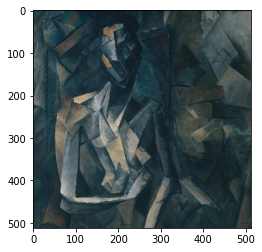

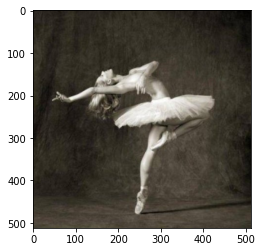

In [5]:
unloader = transforms.ToPILImage() # converts an image from a tensor to a PIL image
plt.ion()

# simple method to graph PIL images
def imshow(tensor, title=None):
  image = tensor.cpu().clone() # clone the tensor, prevent pass by ref
  image = image.squeeze(0) # index 0 is the batch dimension
  image = unloader(image)
  plt.imshow(image)
  if not title:
    plt.title(title)
  plt.pause(0.001) # pausing to update the plots 

# graphing the image we want to style, and the style ref
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


In [6]:
# style transfer uses two different loss functions which will be important
# for getting good results. really important for deep-style-transfer(DST)
# 
# Content Loss: Returns the weighted content distance from the feature maps of 
# a layer (l) processing input (x). distance from x to content image (c)
# MSE from Feature maps of x to c


# !!! this is not a PyTorch Loss function, we need to create an autograd 
#     function and implement the gradient in the backward method !!!
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# helper function for the style loss, very helpful for DST
# gram matrix https://en.wikipedia.org/wiki/Gramian_matrix 
# normalization is really important to prevent early layers from impacting 
# the output, style is learned in deeper layers

def gram_matrix(input):
    a, b, c ,d = input.size()
    # a batch size
    # b number of feature maps
    # c, d | dimensions of a feature map (N=c*d)

    features = input.view(a*b*c*d) # resizing feature map of the layer
    G = torch.mm(features, features.t()) # gram product calculation
    # normalization here
    G_normalized = G.div(a*b*c*d)
    # we can play with results non-normalized to see the impact on the output
    return G_normalized  

# Style Loss: like content loss, uses MSE between two gram matricies
class StyleLoss(nn.Module): 
    def __init__(self, target_features):
        super(StyleLoss, self).__init__()
        # .detach means that this tensor does not need grad 
        self.target = gram_matrix(target_feature).detach()
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

In [ ]:
# READ THIS DECISION FOR WEEK 5
# next we need to build a 19 layer VGG network here, or use the PyTorch one
# I think rebuilding the network will teach us a lot and give us more room to 
# customize VGG
# here is pre-made PyTorch network imported
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG networks are trained on images where each color channel is normalized by 
# mean=[.485, .456, .406] and a std=[.229, .224,.225] 

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# model to normalize input so we can use it to quickly normalize a sequential 
# model
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize the image 
        return (img - self.mean)/ self.std

In [ ]:
default_content_layers = ['conv_4']
default_style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4','conv_5' ]

def get_style_model_and_loss(cnn, normalization_mean, normalization_std,
                             style_img, content_img,
                             content_layers=default_content_layers,
                             style_layers=default_style_layers):
    cnn = copy.deepcopy(cnn)
    
    # using the normalization class to normalize mean and std
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    # list made for accumulating losses
    content_losses = []
    style_losses = []
    
    # using nn.Sequential because we assume that the cnn is already a 
    # nn.Sequential, this lets us put modules to be activated sequentially
    model = nn.Sequential(normalization)
    
    number_of_conv = 0 
    
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            number_of_conv += 1
            name = f'conv{number_of_conv}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{number_of_conv}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{number_of_conv}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{number_of_conv}'
        else:
            raise RuntimeError('Unrecongnized layer:'.format(layer.__class__.__name__))
        model.add_module(name, layer)
        
        if name in content_layers:
            # adding to the conetent loss
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{number_of_conv}', content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            # adding to the style loss
            target_features = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f'style_loss{number_of_conv}', style_loss)
            style_losses.append(style_loss)
    # trim off layers after the last content and style losses
    for i in range(len(model) -1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    model = model[:(i+1)]
        
    return model, style_losses, content_losses
    


In [ ]:
input_img = content_img.clone()
# noise 
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                      content_img, style_img, input_img, num_steps=300,
                      style_weight=1000000, content_weight=1):
    print('Building the model')
    model, style_losses, content_losses = get_style_model_and_loss(cnn, normalization_mean,
                                                                     normalization_std, style_img,
                                                                     input_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0, 1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f'run {run}')
                print(f'Style Loss: {style_score.item()} Content Loss {content_score.item()}')
                print()
                
            return style_score + content_score
        optimizer.step(closure)
    
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()